In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

# Path to aligned data
data_alingned_path = '/mnt/disk2/Arthur_data/B6J3217-2025-07-02T13-13-14_processedData/aligned_data/B6J3217_downsampled_data_Apply halt: 2s_aligned.csv'

data_aligned_csv = pd.read_csv(data_alingned_path)

# Creation of new column with index of each MM
halt_index = 0
halt_indices = []
prev_halt_time = None

for _, row in data_aligned_csv.iterrows():
    if row['Halt Time'] != prev_halt_time:
        halt_index += 1
        prev_halt_time = row['Halt Time']
    halt_indices.append(halt_index-1)

data_aligned_csv['halt_index'] = halt_indices

# Printing every column names to see every variables
col_names = list(data_aligned_csv)
print("\n".join(col_names))


Encoder
Position_0X
Position_0Y
Heartbeat
CumulativeCounts_0X
CumulativeCounts_0Y
dfF_470
dfF_560
dfF_410
z_470
z_560
z_410
Photodiode_int
Encoder_Unwrapped
Motor_Velocity
Motor_Acceleration
Velocity_0X
Acceleration_0X
Velocity_0Y
Acceleration_0Y
saccade_event_eye1
saccade_event_eye2
Time (s)
Halt Time
saccade_probability_eye1
halt_index


In [ ]:
# Setting of the MM wanted for visualisation and annalysis
MM_id = 5
spe_halt_data = data_aligned_csv.loc[data_aligned_csv['halt_index'] == MM_id]

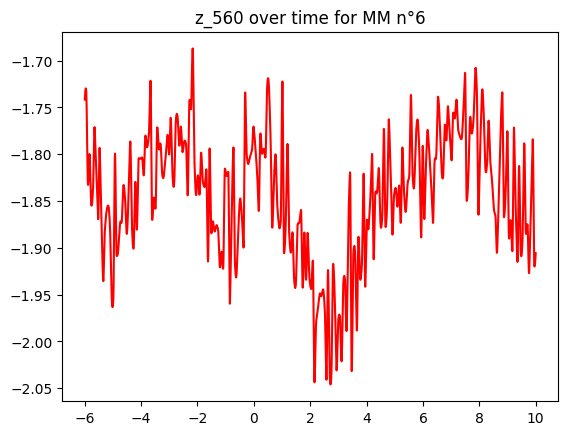

In [ ]:
# Visualisation of the z score 560 for selected MM
plt.plot(spe_halt_data['Time (s)'], spe_halt_data['z_560'], color = 'red')
plt.title(f'z_560 over time for MM n°{MM_id+1}')
plt.show()

In [ ]:
# red = gecko = 560 --> z_560 used for neural activity
# motor_velocity, velocity_0Y, Velocity_0X, saccade_probability_eye1, pupil (elipse ?) diameter

# 
numpy_correlation = np.corrcoef(spe_halt_data['z_560'], spe_halt_data['Motor_Velocity'])[0, 1]
print('NumPy Correlation:', numpy_correlation)

NumPy Correlation: -0.30595489346393273


In [ ]:
x = np.column_stack([spe_halt_data['Motor_Velocity'], spe_halt_data['Velocity_0X'], spe_halt_data['Velocity_0Y']]) # , spe_halt_data['saccade_probability_eye1'], spe_halt_data['saccade_event_eye1']
y = spe_halt_data['z_560']

model = LinearRegression().fit(x, y)

print('multiple linear regression coef:', model.coef_) 
print('multiple linear regression R²:', model.score(x, y)) # R square

multiple linear regression coef: [-0.01450332 -0.10514581 -0.00088886]
multiple linear regression R²: 0.1244629599924224
